Step 1: Environment and Imports

In [1]:
!pip install pretty_midi scipy -q

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
from tensorflow.keras import Sequential, layers
from scipy.ndimage import median_filter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 105.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.3 MB/s eta 0:00:00


Step 2: Parameters and arguments

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/MyDrive/midi_songs" "/content/midi_songs"
midi_folder = "/content/midi_songs"

Mounted at /content/drive


Add here next block of code


In [3]:
# arguments and parameters
sequence_len = 500
window_size = 64
epochs = 50
batch_size = 64
silence_thresh = 0.05

Step 3: MIDI Conversion

In [4]:
def midi_to_sequence(midi_path):
    try:
        midi = pretty_midi.PrettyMIDI(midi_path)
        instrument = midi.instruments[0]
        sequence = np.zeros(sequence_len)
        for note in instrument.notes:
            start = int(note.start * 20)
            end = int(note.end * 20)
            if start < sequence_len:
                sequence[start:min(end, sequence_len)] = note.pitch
        normalized = np.zeros_like(sequence)
        mask = sequence > 0
        normalized[mask] = (sequence[mask] - 21) / 87
        return normalized if normalized.sum() > 0 else None
    except:
        return None


Step 4: Load and Process the MIDI files

In [5]:
def load_midi_files(folder):
    files = glob.glob(os.path.join(folder, "*.mid"))
    songs = []
    for path in files:
        seq = midi_to_sequence(path)
        if seq is not None:
            songs.append(seq)
    return np.array(songs)


Step 5: Create the Training Data

In [6]:
def create_training_data(songs, window_size):
    X, y = [], []
    for song in songs:
        for i in range(len(song) - window_size - 1):
            X.append(song[i:i + window_size])
            y.append(song[i + window_size])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, 1)
    return X, y


Step 6: Building the LSTM Model

In [7]:
def build_model(window_size):
    model = Sequential([
        layers.LSTM(128, input_shape=(window_size, 1), return_sequences=True),
        layers.LSTM(128),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='mse', optimizer='adam')
    return model


Step 7: Generate the Melody

In [8]:
def generate_melody(model, seed_song, window_size, length=300):
    generated = list(seed_song[:window_size])
    for _ in range(length):
        window = np.array(generated[-window_size:]).reshape(1, window_size, 1)
        prediction = model.predict(window, verbose=0)[0, 0]
        noise = np.random.normal(0, 0.05)
        prediction = np.clip(prediction + noise, 0, 1)
        generated.append(prediction)
    smoothed = median_filter(generated, size=5)
    return smoothed


Step 8: Convert back to MIDI

In [9]:
def save_as_midi(sequence, filename="generated.mid"):
    midi = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)
    current_pitch = None
    start_time = 0
    step_duration = 0.05
    for i, value in enumerate(sequence):
        if value > silence_thresh:
            pitch = int(21 + value * 87)
        else:
            pitch = 0
        if pitch != current_pitch:
            if current_pitch is not None and current_pitch > 0:
                end_time = i * step_duration
                note = pretty_midi.Note(
                    velocity=80,
                    pitch=current_pitch,
                    start=start_time,
                    end=end_time
                )
                piano.notes.append(note)
            current_pitch = pitch
            start_time = i * step_duration
    if current_pitch is not None and current_pitch > 0:
        note = pretty_midi.Note(
            velocity=80,
            pitch=current_pitch,
            start=start_time,
            end=len(sequence) * step_duration
        )
        piano.notes.append(note)
    midi.instruments.append(piano)
    midi.write(filename)


Step 9: Put everything together and train the model

In [12]:
songs = load_midi_files(midi_folder)
X_train, y_train = create_training_data(songs, window_size)
model = build_model(window_size)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
melody = generate_melody(model, songs[32], window_size, length=300)
save_as_midi(melody, "generated_melody.mid")

Epoch 1/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0325
Epoch 2/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0201
Epoch 3/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0200
Epoch 4/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0196
Epoch 5/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0196
Epoch 6/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0193
Epoch 7/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0184
Epoch 8/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0181
Epoch 9/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0168
Epoch 10/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0164
Epoch 11/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0193
Epoch 12/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0163
Epoch 13/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0151
Epoch 14/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0144
Epoch 15/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step

In [17]:
melody = generate_melody(model, songs[23], window_size, length=300)
save_as_midi(melody, "generated_melody.mid")

BONUS: Plot it

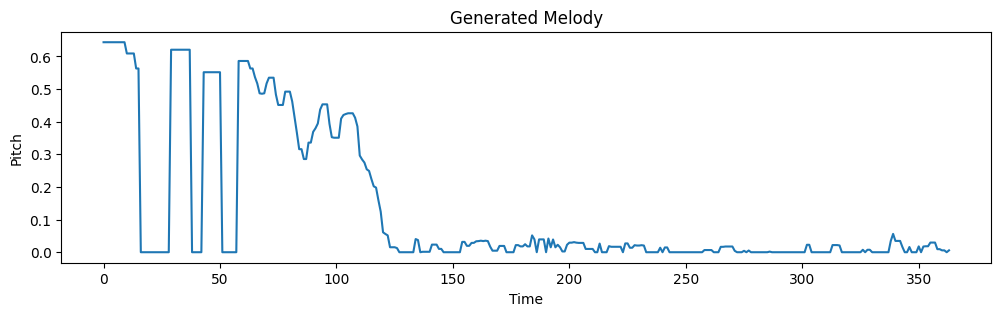

In [16]:
plt.figure(figsize=(12, 3))
plt.plot(melody)
plt.title("Generated Melody")
plt.xlabel("Time")
plt.ylabel("Pitch")
plt.show()